```Name: Wong Wen Bing```    
```Admin #: 230436M```  
```PEM GROUP: AA2303```

# **Part 3: Text Classification Notebook (3/3)** 
This part will comprise of the text classification processes, followed by evaluation. 

### <strong><ins>Import Necessary Libraries </strong></ins>

We first start by importing the necessary libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report,confusion_matrix

import pickle


In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,content,rating,airline,cleaned_text,word_count,char_count,avg_word_length,sentiment_score,subjectivity_score,rating_category,sentiment_agreement,rating_encoded,airlines
0,0,0,Southwest's Boarding Process has gotten comple...,3.0,Southwest Airlines,southwest 's boarding process gotten completel...,156,1106,7.044586,0.030208,0.351562,Neutral,0,1,Southwest Airlines
1,1,1,Flew Sydney to Auckland in January 2017 with t...,5.0,Emirates,flew sydney auckland january 2017 wife break r...,119,826,6.883333,0.388095,0.580952,Positive,1,2,Emirates
2,2,2,NEVER fly with scoot. I booked a ticket almost...,1.0,Scoot,never fly scoot booked ticket almost 1.5 year ...,96,600,6.185567,0.036364,0.486490,Negative,0,0,Scoot
3,3,3,✅ Trip Verified | Melbourne to London return ...,3.0,Singapore Airlines,melbourne london return via singapore a-350 me...,141,923,6.500000,0.279134,0.497489,Neutral,0,1,Singapore Airlines
4,4,4,MAD-DXB-SYD economy. A380 great seats B777 imp...,3.0,Emirates,mad-dxb-syd economy a380 great seat b777 impos...,19,127,6.350000,-0.077778,0.758333,Neutral,0,1,Emirates


### <strong><ins>Additional Data Cleaning </strong></ins>

Remove unnecessary columns: 
- index columns such as 'Unnamed: 0.1'
- 'airline': using 'airlines' as target variable
- 'content': 'using 'cleaned_text' 
- 'rating': using 'rating_encoded instead
- 'rating_category': using 'rating_encoded instead

Other steps: 
- filter out words with word count of less than 50.

In [3]:
df = df.drop(['airline', 'Unnamed: 0.1', 'Unnamed: 0','content', 'rating','rating_category'],axis=1)
df.head()

,cleaned_text,word_count,char_count,avg_word_length,sentiment_score,subjectivity_score,sentiment_agreement,rating_encoded,airlines
0,southwest 's boarding process gotten completel...,156,1106,7.044586,0.030208,0.351562,0,1,Southwest Airlines
1,flew sydney auckland january 2017 wife break r...,119,826,6.883333,0.388095,0.580952,1,2,Emirates
2,never fly scoot booked ticket almost 1.5 year ...,96,600,6.185567,0.036364,0.486490,0,0,Scoot
3,melbourne london return via singapore a-350 me...,141,923,6.500000,0.279134,0.497489,0,1,Singapore Airlines
4,mad-dxb-syd economy a380 great seat b777 impos...,19,127,6.350000,-0.077778,0.758333,0,1,Emirates


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12207 entries, 0 to 12206
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cleaned_text         12207 non-null  object 
 1   word_count           12207 non-null  int64  
 2   char_count           12207 non-null  int64  
 3   avg_word_length      12207 non-null  float64
 4   sentiment_score      12207 non-null  float64
 5   subjectivity_score   12207 non-null  float64
 6   sentiment_agreement  12207 non-null  int64  
 7   rating_encoded       12207 non-null  int64  
 8   airlines             12207 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 858.4+ KB


In [5]:
df['cleaned_text'] = df['cleaned_text'].where(df['word_count'] >= 50, np.NaN)
df.dropna(inplace=True)

<ins> Label Encoding</ins>       
To fit the model properly, we will now conduct label encoding to convert the airlines into numerical values.

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['airlines_encoded']=le.fit_transform(df['airlines'])

In [7]:
label_mapping = dict(enumerate(le.classes_))
label_mapping

{0: 'British Airways',
 1: 'Emirates',
 2: 'Ryanair',
 3: 'Scoot',
 4: 'Singapore Airlines',
 5: 'Southwest Airlines'}

### <strong><ins>Feature Importance </strong>
As a rough gauge, we will now train a model to examine the importance of the numerical variables.

In [8]:
X = df.drop(['cleaned_text', 'airlines','airlines_encoded'],axis=1)
Y = df['airlines_encoded']
Y

0        5
1        1
2        3
3        4
6        1
        ..
12200    5
12201    1
12203    1
12205    5
12206    2
Name: airlines_encoded, Length: 7438, dtype: int64

Accuracy: 0.23548387096774193
Precision (Weighted): 0.23356138421270803
Recall (Weighted): 0.23548387096774193
F1-score (Weighted): 0.23052035312927271


Text(0.5, 1.0, 'Feature Importance')

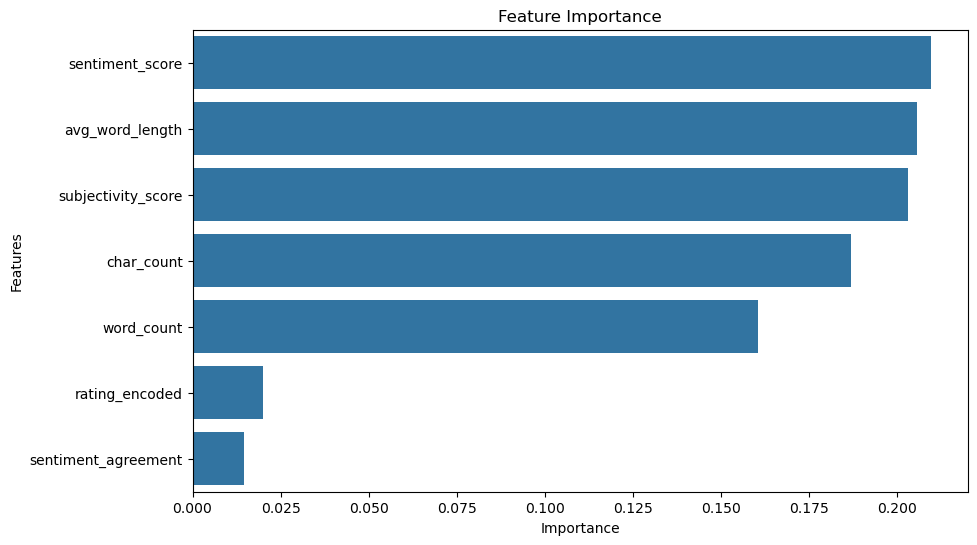

In [9]:
rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rf_classifier = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1-score (Weighted):", f1)

feature_importance = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Features', orient="h")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")

As we can observe, we can see that the numerical features are currently not that effective at conducting modelling and identifying trends. This highlights the **importance of the text features**.     
As a general trend we can also observe that the sentiment_score, subjectivity_score and avg_word_length are rather important variables. However, average_word_length would not be useful in such circumstances due to the nature of the model where it is more important to examine sentiments and subjectivity to adequately classify each model better.

### <strong><ins> Preparing for Training </strong></ins>

We now prepare the dataset for training for both text and numerical features

We first start off with 3 X variables - cleaned_text, sentiment_score and subjectivity_score

In [10]:
X= df[['cleaned_text','sentiment_score', 'subjectivity_score',
       ]]
Y = df['airlines_encoded']

Next, we will split the data

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=30)

After splitting the datasets, we will need to do feature engineering for the text features. As such, we will first split the datasets into text and numerical features

In [12]:
x_train_text = x_train['cleaned_text']
x_train_numeric= x_train.drop('cleaned_text',axis=1)
x_test_text = x_test['cleaned_text']
x_test_numeric= x_test.drop('cleaned_text',axis=1)

We now conduct scaling for our numerical features, conducting scaling from 0 to 2 only.

In [13]:
# Scale the data to the range [0, 2]
scaler = MinMaxScaler(feature_range=(0, 2))
x_train_numeric_scaled = scaler.fit_transform(x_train_numeric)
x_test_numeric_scaled = scaler.transform(x_test_numeric)


In [31]:
with open('scaling.pkl','wb') as f:
    pickle.dump(scaler,f)

In [14]:
x_train_numeric_scaled

array([[1.33189746, 0.62777778],
       [1.22538959, 1.10555556],
       [1.47220865, 1.16071429],
       ...,
       [1.46488105, 1.13367347],
       [1.1856437 , 1.02747253],
       [1.59411821, 0.98125   ]])

With the scaling down, we now convert this data back to the dataframe, x_train_numeric and x_test_numeric

In [15]:
x_train_scaled_df = pd.DataFrame(x_train_numeric_scaled, columns=x_train_numeric.columns, index=x_train_numeric.index)
x_test_scaled_df = pd.DataFrame(x_test_numeric_scaled, columns=x_test_numeric.columns, index=x_test_numeric.index)

In [16]:
x_train_numeric=x_train_scaled_df.reset_index(drop=True)
x_test_numeric=x_test_scaled_df.reset_index(drop=True)

In [17]:
x_train_numeric

,sentiment_score,subjectivity_score
0,1.331897,0.627778
1,1.225390,1.105556
2,1.472209,1.160714
3,1.087488,1.155303
4,1.196146,1.203061
...,...,...
5573,1.100215,0.925926
5574,1.615186,1.231481
5575,1.464881,1.133673
5576,1.185644,1.027473


### <strong><ins> Vectorising </ins></strong>
With the numerical features processed, we now conduct vectorisation. In this series, we will conduct 2 methods - Count Vectorization and Tfidf Vectorization.

#### <ins> Method 1: Count Vectorization </ins>
We now use Count Vectorizer with an ngram range of 2 and maximum features of 5000

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,2), max_features=5000) 
x_train_countvectorised = cv.fit_transform(x_train_text)
x_test_countvectoised = cv.transform(x_test_text)


After conducting the vectorising, we will convert the data to a dataframe to concatenate to form our first training set to represent count vectorising.

In [19]:
x_train_countvectorised=pd.DataFrame(x_train_countvectorised.toarray(), columns=cv.get_feature_names_out())
x_train_countvectorised.reset_index(drop=True,inplace=True)
x_test_countvectorised=pd.DataFrame(x_test_countvectoised.toarray(), columns=cv.get_feature_names_out())
x_test_countvectorised.reset_index(drop=True,inplace=True)

In [20]:
x_train_finalcv = pd.concat([x_train_countvectorised,x_train_numeric],axis=1)
x_test_finalcv= pd.concat([x_test_countvectorised,x_test_numeric],axis=1)

In [21]:
x_train_finalcv

,00,000,01,05,07,09,10,10 10,10 15,10 day,...,young,young child,young lady,yr,zealand,zero,zone,zurich,sentiment_score,subjectivity_score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.331897,0.627778
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.225390,1.105556
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.472209,1.160714
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.087488,1.155303
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.196146,1.203061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.100215,0.925926
5574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.615186,1.231481
5575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.464881,1.133673
5576,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.185644,1.027473


In [30]:
import pickle
with open('cv.pkl', 'wb') as f:
    pickle.dump(cv,f)

#### <ins>Method 2: Tfidf Vectorisation</ins>    
We now use Tfidf Vectorization to conduct our vectorization with an ngram range of 2 and max_features of 500. The reason for the Tfidf vectorization to only be 500 is to prevent high dimensionality. Having tested with 5000 features previously, it resulted in extremely low accuracy of 0.29435.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(ngram_range=(1,2), max_features=500)
x_train_tfidfvectorised = tv.fit_transform(x_train_text)
x_test_tfidfvectoised = tv.transform(x_test_text)

In [23]:
x_train_tfidfvectorised=pd.DataFrame(x_train_tfidfvectorised.toarray(), columns=tv.get_feature_names_out())
x_train_tfidfvectorised.reset_index(drop=True,inplace=True)
x_test_tfidfvectorised=pd.DataFrame(x_test_tfidfvectoised.toarray(), columns=tv.get_feature_names_out())

In [24]:
x_train_finaltv = pd.concat([x_train_tfidfvectorised,x_train_numeric],axis=1)
x_test_finaltv= pd.concat([x_test_tfidfvectorised,x_test_numeric],axis=1)

In [25]:
x_train_finaltv

,10,12,15,20,24,30,40,45,50,777,...,working,world,worse,worst,worth,wrong,year,yet,sentiment_score,subjectivity_score
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.331897,0.627778
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.225390,1.105556
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.472209,1.160714
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.087488,1.155303
4,0.0,0.0,0.0,0.0,0.0,0.270567,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.196146,1.203061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.100215,0.925926
5574,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.615186,1.231481
5575,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.464881,1.133673
5576,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.159964,0.0,0.0,...,0.0,0.0,0.0,0.123832,0.0,0.0,0.0,0.0,1.185644,1.027473


### <strong><ins>Modelling Process </strong></ins>

We will now use a number of ways to conduct our modelling

In [26]:
models_list =[
    LogisticRegression(multi_class='multinomial'),
    MultinomialNB(),
    LinearSVC(random_state=42), 
    RandomForestClassifier(random_state=42), 
    SGDClassifier(random_state=42),
    CatBoostClassifier(verbose=0, random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]

results = []

We will append the results to a dictionary before displaying in a dataframe.

In [27]:
for model in models_list:
    
    # Dictionary to store results for the current model
    model_results = {'Model': str(model)}
    
    # Evaluate for CountVectorizer
    model.fit(x_train_finalcv, y_train)
    y_pred_cv = model.predict(x_test_finalcv)
    model_results[('Count Vectorizer', 'Accuracy')] = accuracy_score(y_test, y_pred_cv)
    model_results[('Count Vectorizer', 'F1-Weighted')] = f1_score(y_test, y_pred_cv, average='weighted')
    model_results[('Count Vectorizer', 'F1-Macro')] = f1_score(y_test, y_pred_cv, average='macro')
    
    # Evaluate for TfidfVectorizer
    model.fit(x_train_finaltv, y_train)
    y_pred_tv = model.predict(x_test_finaltv)
    model_results[('Tfidf Vectorizer', 'Accuracy')] = accuracy_score(y_test, y_pred_tv)
    model_results[('Tfidf Vectorizer', 'F1-Weighted')] = f1_score(y_test, y_pred_tv, average='weighted')
    model_results[('Tfidf Vectorizer', 'F1-Macro')] = f1_score(y_test, y_pred_tv, average='macro')
    
    # Append results for the current model
    results.append(model_results)
    print(model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')
MultinomialNB()
LinearSVC(random_state=42)
RandomForestClassifier(random_state=42)
SGDClassifier(random_state=42)


KeyboardInterrupt: 

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Set 'Model' as the index
results_df.set_index('Model', inplace=True)

results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)

results_df

Count Vectorizer  \
                                                           Accuracy   
Model                                                                 
LogisticRegression(multi_class='multinomial')              0.938710   
MultinomialNB()                                            0.902688   
LinearSVC(random_state=42)                                 0.943548   
RandomForestClassifier(random_state=42)                    0.946237   
SGDClassifier(random_state=42)                             0.933333   
<catboost.core.CatBoostClassifier object at 0x1...         0.933871   
KNeighborsClassifier()                                     0.679570   
AdaBoostClassifier(random_state=42)                        0.808065   
GradientBoostingClassifier(random_state=42)                0.938172   

                                                                          \
                                                   F1-Weighted  F1-Macro   
Model                                                                      
LogisticRegression(multi_class='multinomial')         0.938770  0.932092   
MultinomialNB()                                       0.903471  0.892339   
LinearSVC(random_state=42)                            0.943528  0.936304   
RandomForestClassifier(random_state=42)               0.945924  0.939281   
SGDClassifier(random_state=42)                        0.933252  0.926826   
<catboost.core.CatBoostClassifier object at 0x1...    0.933810  0.927568   
KNeighborsClassifier()                                0.676739  0.654202   
AdaBoostClassifier(random_state=42)                   0.802236  0.773713   
GradientBoostingClassifier(random_state=42)           0.938085  0.930756   

                                                   Tfidf Vectorizer  \
                                                           Accuracy   
Model                                                                 
LogisticRegression(multi_class='multinomial')              0.926882   
MultinomialNB()                                            0.869355   
LinearSVC(random_state=42)                                 0.926344   
RandomForestClassifier(random_state=42)                    0.925806   
SGDClassifier(random_state=42)                             0.930108   
<catboost.core.CatBoostClassifier object at 0x1...         0.923656   
KNeighborsClassifier()                                     0.784946   
AdaBoostClassifier(random_state=42)                        0.864516   
GradientBoostingClassifier(random_state=42)                0.926344   

                                                                          
                                                   F1-Weighted  F1-Macro  
Model                                                                     
LogisticRegression(multi_class='multinomial')         0.926662  0.918787  
MultinomialNB()                                       0.867538  0.853668  
LinearSVC(random_state=42)                            0.926415  0.918423  
RandomForestClassifier(random_state=42)               0.925654  0.916920  
SGDClassifier(random_state=42)                        0.930144  0.923168  
<catboost.core.CatBoostClassifier object at 0x1...    0.923656  0.916628  
KNeighborsClassifier()                                0.783345  0.772201  
AdaBoostClassifier(random_state=42)                   0.864775  0.857140  
GradientBoostingClassifier(random_state=42)           0.926308  0.917668

In [ ]:
new_values = ["Logistic Regression",
              "MultinomialNB","Linear SVC","Random Forest Classifier","SGD Classifier",
            "Cat Boost Classifier", "KNeighbors Classifier",
              "Ada Boost Classifier", 
              "Gradient Boosting Classifier"
              ]  # List must match the number of rows

results_df.reset_index(inplace=True)

In [ ]:
results_df.loc[results_df.index, "Model"] = new_values  # Directly replace values

In [ ]:
results = results_df.set_index('Model')
results

Count Vectorizer                        \
                                     Accuracy F1-Weighted  F1-Macro   
Model                                                                 
Logistic Regression                  0.938710    0.938770  0.932092   
MultinomialNB                        0.902688    0.903471  0.892339   
Linear SVC                           0.943548    0.943528  0.936304   
Random Forest Classifier             0.946237    0.945924  0.939281   
SGD Classifier                       0.933333    0.933252  0.926826   
Cat Boost Classifier                 0.933871    0.933810  0.927568   
KNeighbors Classifier                0.679570    0.676739  0.654202   
Ada Boost Classifier                 0.808065    0.802236  0.773713   
Gradient Boosting Classifier         0.938172    0.938085  0.930756   

                             Tfidf Vectorizer                        
                                     Accuracy F1-Weighted  F1-Macro  
Model                                                                
Logistic Regression                  0.926882    0.926662  0.918787  
MultinomialNB                        0.869355    0.867538  0.853668  
Linear SVC                           0.926344    0.926415  0.918423  
Random Forest Classifier             0.925806    0.925654  0.916920  
SGD Classifier                       0.930108    0.930144  0.923168  
Cat Boost Classifier                 0.923656    0.923656  0.916628  
KNeighbors Classifier                0.784946    0.783345  0.772201  
Ada Boost Classifier                 0.864516    0.864775  0.857140  
Gradient Boosting Classifier         0.926344    0.926308  0.917668

We can observe that on average, most of the models are doing rather well, except for K Neighours and AdaBoost. Other than that, most of them are relatively well performing, we now shortlist the below models for further testing and evaluation. 

- Logistic Regression with Count Vectorizer
- Linear SVC with Count Vectorizer
- Rnandom Forest with Count Vectorizer

#### <ins>Model 1: Logistic Regression with Count Vectorizer </ins>

We now first start off with a base model. In this case, we use multnomial as the multi_class to ensure diversification.

In [28]:
from sklearn.linear_model import LogisticRegression
lr_cv=LogisticRegression(multi_class='multinomial')
lr_cv.fit(x_train_finalcv,y_train)
import pickle
with open ('logreg.pkl','wb') as f:
    pickle.dump(lr_cv,f)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [239]:
y_pred=lr_cv.predict(x_test_finalcv)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9387096774193548
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       392
           1       0.98      0.95      0.96       388
           2       0.93      0.96      0.95       282
           3       0.89      0.85      0.87       177
           4       0.89      0.91      0.90       314
           5       0.92      0.97      0.95       307

    accuracy                           0.94      1860
   macro avg       0.93      0.93      0.93      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9387699017109956
macro f1 score: 0.9320918001536382
      


This model is performing relatively well as well, with only class 3 being more imbalanced. As such, we can continue with finetuning this base model.

In [240]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'solver': ['newton-cg', 'saga', 'lbfgs'],  # Solvers supporting multinomial
    'max_iter': [100, 200, 500]  # Number of iterations
}


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lr_cv,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    # cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    # n_jobs=-1  # Use all available CPU cores
)

# Fit RandomizedSearchCV
random_search.fit(x_train_finalcv, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model

RandomizedSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [100, 200, 500],
                                        'solver': ['newton-cg', 'saga',
                                                   'lbfgs']},
                   random_state=42, scoring='accuracy')

In [241]:
best_model = random_search.best_estimator_
# Print best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")
y_pred = best_model.predict(x_test_finalcv)

# Generate classification report
print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')

Best Hyperparameters: {'solver': 'saga', 'max_iter': 100, 'C': 29.763514416313132}

Accuracy: 0.9376344086021505
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       392
           1       0.98      0.95      0.97       388
           2       0.92      0.96      0.94       282
           3       0.88      0.85      0.87       177
           4       0.90      0.90      0.90       314
           5       0.93      0.97      0.95       307

    accuracy                           0.94      1860
   macro avg       0.93      0.93      0.93      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9376192802026789
macro f1 score: 0.9307122177656288
      


The performance between the finetuned model and the current model is very very small. We will print the confusion matrix to investigate further.

In [243]:
logreg_bestbasemodel= best_model
logreg_bestbasemodel

LogisticRegression(C=29.763514416313132, multi_class='multinomial',
                   solver='saga')

In [352]:
logreg_bestbasemodel

LogisticRegression(C=29.763514416313132, multi_class='multinomial',
                   solver='saga')

In [353]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(logreg_bestbasemodel, x_train_finalcv, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model

Cross-Validation Accuracy Scores: [0.94802867 0.93727599 0.94892473 0.94349776 0.94887892]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### **SMOTE** 
SMOTE stands for Synthetic Minority Oversampling Technique. It’s a technique used in machine learning to address imbalanced datasets.

1. Identify the Imbalance: You start by recognizing that your data has a minority class, like rare disease cases in a medical dataset.
2. Focus on the minority: SMOTE specifically creates new data points for the minority class, not the majority.
3. Create synthetic samples: It analyzes existing minority data points and generates new ones similar to them.
4. Increase minority: By adding these synthetic samples, SMOTE balances the data, giving the model a better chance to learn the minority class.

In this situation, SMOTE is used to address the different classes to achieve a better data balance to ensure a more balanced performance. 

Source: <a href="https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/"> Analytics Vidhya </a>

In [354]:
smote = SMOTE() 
x_train_cv_resampled, y_resampled = smote.fit_resample(x_train_finalcv, y_train)

After resampling the data, we examine the distribution

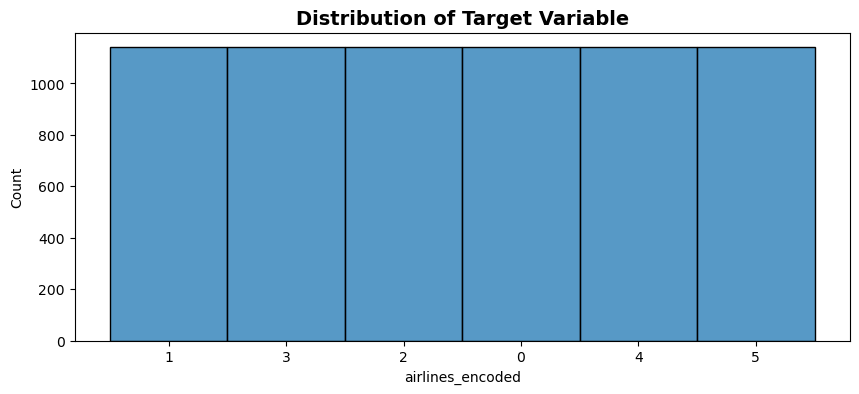

In [361]:
plt.figure(figsize=(10,4))
y_resampled = y_resampled.astype(str)

sns.histplot(y_resampled)
plt.title('Distribution of Target Variable',fontsize=14,weight='bold')
plt.show()

As we can see, the distribution is rather even more. We now move on to our mode

In [245]:
lr_cv_smoted=LogisticRegression(multi_class='multinomial')
lr_cv_smoted.fit(x_train_cv_resampled,y_resampled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')

In [246]:
y_pred=lr_cv_smoted.predict(x_test_finalcv)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9274193548387096
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       392
           1       0.97      0.95      0.96       388
           2       0.93      0.94      0.93       282
           3       0.83      0.85      0.84       177
           4       0.88      0.89      0.89       314
           5       0.92      0.97      0.95       307

    accuracy                           0.93      1860
   macro avg       0.92      0.92      0.92      1860
weighted avg       0.93      0.93      0.93      1860

weighted f1 score: 0.9276245390651536
macro f1 score: 0.9195725702865704
      


As we can see, the model performs fairly poorer than the base model. As such, it is not chosen for finetuning.

##### **Tomek Links**
<ins>About Tomek Links </ins>      
Tomek Links is one of a modification from Condensed Nearest Neighbors (CNN, not to be confused with Convolutional Neural Network) undersampling technique that is developed by Tomek (1976). Unlike the CNN method that are only randomly select the samples with its k nearest neighbors from the majority class that wants to be removed, the Tomek Links method uses the rule to selects the pair of observation (say, a and b) that are fulfilled these properties:
- The observation a‘s nearest neighbor is b.
- The observation b‘s nearest neighbor is a.
- Observation a and b belong to a different class. That is, a and b belong to the minority and majority class (or vice versa), respectively.

This method can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data (i.e. the data from the majority class that is closest with the minority class data, thus make it ambiguous to distinct), and then remove it.

Source: <a href='https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc/'> Towards Data Science </a>

<ins>Implementation </ins>    
In this jupyter notebook, instead of using SMOTE and Tomek Links together, as suggested by the article, I set out to investigate of only using TomekLinks as part of undersampling.

In [247]:
tl = TomekLinks()
x_train_cv_tomekked, y_resampled = tl.fit_resample(x_train_finalcv, y_train)

We now examine the distribution.

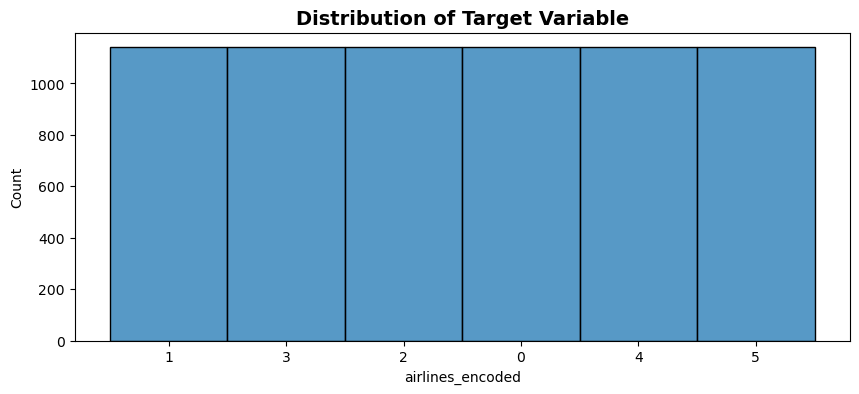

In [362]:
plt.figure(figsize=(10,4))
y_resampled = y_resampled.astype(str)

sns.histplot(y_resampled)
plt.title('Distribution of Target Variable',fontsize=14,weight='bold')
plt.show()

As we can see, the distribution for it being undersampled is also very balance. Let's now continue on to our modelling process.

In [248]:
lr_cv_tomek=LogisticRegression(multi_class='multinomial')
lr_cv_tomek.fit(x_train_cv_tomekked,y_resampled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')

In [249]:
y_pred=lr_cv_tomek.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9338709677419355
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       392
           1       0.98      0.95      0.96       388
           2       0.93      0.95      0.94       282
           3       0.88      0.85      0.86       177
           4       0.89      0.91      0.90       314
           5       0.92      0.97      0.94       307

    accuracy                           0.93      1860
   macro avg       0.93      0.93      0.93      1860
weighted avg       0.93      0.93      0.93      1860

weighted f1 score: 0.9338842340981087
macro f1 score: 0.9270480975563519
      


As we can observe, the results of this model is much better than that of SMOTE. This would mean that the dataset in this scenario is better off focusing on undersampling the training set than oversampling using SMOTE. Hence, I decided to shortlist this model for further finetuning.

<ins> Finetuning </ins>      
With a relevantly good model, finetuning of the model is now conducted as shown below.

In [332]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'solver': ['newton-cg', 'saga', 'lbfgs'],  # Solvers supporting multinomial
    'max_iter': [100, 200, 500]  # Number of iterations
}


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lr_cv_tomek,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    # cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    # n_jobs=-1  # Use all available CPU cores
)

# Fit RandomizedSearchCV
random_search.fit(x_train_cv_tomekked, y_resampled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model

RandomizedSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [100, 200, 500],
                                        'solver': ['newton-cg', 'saga',
                                                   'lbfgs']},
                   random_state=42, scoring='accuracy')

In [334]:
best_model = random_search.best_estimator_
# Print best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")
y_pred = best_model.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')

Best Hyperparameters: {'solver': 'saga', 'max_iter': 100, 'C': 545.5594781168514}

Accuracy: 0.9376344086021505
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       392
           1       0.98      0.95      0.97       388
           2       0.93      0.95      0.94       282
           3       0.88      0.86      0.87       177
           4       0.90      0.91      0.90       314
           5       0.93      0.97      0.95       307

    accuracy                           0.94      1860
   macro avg       0.93      0.93      0.93      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9376468499340641
macro f1 score: 0.9309870015210198
      


In [337]:
logreg_tomek=best_model
logreg_tomek

LogisticRegression(C=545.5594781168514, multi_class='multinomial',
                   solver='saga')

We can see that the model performs slightly poorer, we can investigate now to see what is the difference.

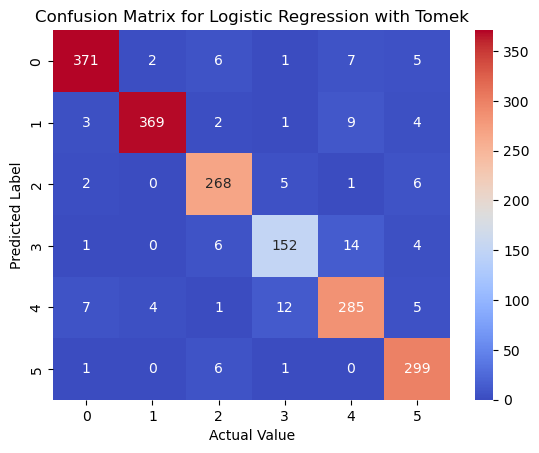

In [366]:
y_pred=logreg_tomek.predict(x_test_finalcv)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix for Logistic Regression with Tomek")
plt.show()

With the above confusion matrix, we can observe that the performance is rather good, and we can move on to our next model.

#### <ins> Model 2: Linear SVC with Count Vectorizer </ins>
We now continue the modelling process by using a Linear SVC base model.

In [291]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42)

In [292]:
svm.fit(x_train_finalcv,y_train)

LinearSVC(random_state=42)

In [293]:
y_pred=svm.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9435483870967742
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       392
           1       0.98      0.96      0.97       388
           2       0.92      0.95      0.94       282
           3       0.88      0.86      0.87       177
           4       0.91      0.91      0.91       314
           5       0.94      0.98      0.96       307

    accuracy                           0.94      1860
   macro avg       0.94      0.94      0.94      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9435281998538186
macro f1 score: 0.9363039377282202
      


We can observe that the model performs better than that of the Logistic Regression. Let's now conduct some finetuning.

In [294]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'max_iter': [1000, 5000, 10000],  # Number of iterations
    'loss': ['hinge', 'squared_hinge'],  # Loss functions supported by LinearSVC
    'dual': [True, False]  # Whether to solve the dual or primal optimization problem
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',
    random_state=42,
)


# Fit RandomizedSearchCV
random_search.fit(x_train_finalcv, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py", line 317, in fit
    self.coef_, self.

RandomizedSearchCV(estimator=LinearSVC(random_state=42),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'dual': [True, False],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [1000, 5000, 10000]},
                   random_state=42, scoring='accuracy')

In [295]:
best_model = random_search.best_estimator_
# Print best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")
y_pred = best_model.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')

Best Hyperparameters: {'max_iter': 1000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.08858667904100823}

Accuracy: 0.9435483870967742
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       392
           1       0.98      0.96      0.97       388
           2       0.93      0.96      0.94       282
           3       0.88      0.86      0.87       177
           4       0.91      0.91      0.91       314
           5       0.94      0.98      0.96       307

    accuracy                           0.94      1860
   macro avg       0.94      0.94      0.94      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9435006879822486
macro f1 score: 0.9364148309628093
      


After finetuning, it is observed that the model performs slightly poorer than that of the finetuned one. Furthermore, we can observe that the model's performance is rather inconsistent such as for class3 and class4 where the model performance is poorer than that for the other classes. We now try other methods of class weights to deal with this balance.

In [296]:
linearsvm_bestmodel = best_model
linearsvm_bestmodel

LinearSVC(C=0.08858667904100823, dual=False, random_state=42)

As we can observe some issues with the sampling especially for class 3 witht the most imbalance let's try smote and Tomek as well

##### **SMOTE** 

We now continue our modelling by using SMOTE with SVC. SMOTE will ensure equal target variable distribution, as represented previously.

In [297]:
smote = SMOTE() 
x_train_cv_resampled, y_resampled = smote.fit_resample(x_train_finalcv, y_train)

We now conduct the modelling

In [298]:
svm_smoted = LinearSVC(random_state=42)
svm_smoted.fit(x_train_cv_resampled,y_resampled)

LinearSVC(random_state=42)

In [299]:
y_pred=svm_smoted.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9198924731182796
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       392
           1       0.96      0.95      0.96       388
           2       0.92      0.93      0.92       282
           3       0.80      0.85      0.82       177
           4       0.89      0.88      0.88       314
           5       0.90      0.94      0.92       307

    accuracy                           0.92      1860
   macro avg       0.91      0.91      0.91      1860
weighted avg       0.92      0.92      0.92      1860

weighted f1 score: 0.920339718622021
macro f1 score: 0.9103209546951684
      


As we can observe, the model performs much worse than that of the base model. As such, we will not consider this model for finetuning.

##### **Tomek Links**

We will now conduct modelling using TomekLinks. Tomek Links will undersample the dataset to ensure an equal balance.

In [300]:
tl = TomekLinks()
x_traincv_tomekked, y_resampled = tl.fit_resample(x_train_finalcv, y_train)

After setting the datasets, we now conduct modelling

In [301]:
svm_tomek = LinearSVC(random_state=42)
svm_tomek.fit(x_train_cv_tomekked,y_resampled)

LinearSVC(random_state=42)

In [302]:
y_pred=svm_tomek.predict(x_test_finalcv)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9413978494623656
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       392
           1       0.98      0.96      0.97       388
           2       0.92      0.95      0.93       282
           3       0.88      0.86      0.87       177
           4       0.91      0.92      0.91       314
           5       0.94      0.98      0.96       307

    accuracy                           0.94      1860
   macro avg       0.93      0.93      0.93      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9413905136784324
macro f1 score: 0.9343701846127287
      


As we can observe, the model performs slightly worse than that of the base model. As such, we can attempt to finetune the model even more.

In [303]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'max_iter': [1000, 5000, 10000],  # Number of iterations
    'loss': ['hinge', 'squared_hinge'],  # Loss functions supported by LinearSVC
    'dual': [True, False]  # Whether to solve the dual or primal optimization problem
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm_tomek,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',
    random_state=42,
)


# Fit RandomizedSearchCV
random_search.fit(x_train_cv_tomekked, y_resampled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py", line 317, in fit
    self.coef_, self.

RandomizedSearchCV(estimator=LinearSVC(random_state=42),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'dual': [True, False],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [1000, 5000, 10000]},
                   random_state=42, scoring='accuracy')

In [304]:
best_model = random_search.best_estimator_
# Print best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")
y_pred = best_model.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')

Best Hyperparameters: {'max_iter': 1000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.08858667904100823}

Accuracy: 0.9413978494623656
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       392
           1       0.97      0.96      0.97       388
           2       0.93      0.95      0.94       282
           3       0.89      0.86      0.88       177
           4       0.91      0.91      0.91       314
           5       0.94      0.98      0.96       307

    accuracy                           0.94      1860
   macro avg       0.94      0.93      0.93      1860
weighted avg       0.94      0.94      0.94      1860

weighted f1 score: 0.9413126695541623
macro f1 score: 0.93493451741107
      


As we can observe, the model somehow performs slightly worse than the pre-finetuned model. As such, let's save this model and attempt it on our unseen data later.

In [305]:
linearsvm_tomek=best_model
linearsvm_bestmodel

LinearSVC(C=0.08858667904100823, dual=False, random_state=42)

In [306]:
import pickle
with open ('svm_tomek.pkl','wb') as f:
    pickle.dump(linearsvm_tomek,f)

In [307]:
import pickle
with open ('svm.pkl','wb') as f:
    pickle.dump(linearsvm_bestmodel,f)

#### <ins> Model 3: Random Forest with Count Vectorizer </ins>
Lastly, we will conclude our modelling process by using Random Forest

We first start off with the best model

In [308]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_finalcv,y_train)

RandomForestClassifier(random_state=42)

In [309]:
y_pred=rf.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.946236559139785
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       392
           1       0.98      0.96      0.97       388
           2       0.93      0.97      0.95       282
           3       0.96      0.81      0.88       177
           4       0.89      0.94      0.91       314
           5       0.94      0.98      0.96       307

    accuracy                           0.95      1860
   macro avg       0.95      0.94      0.94      1860
weighted avg       0.95      0.95      0.95      1860

weighted f1 score: 0.9459243364904442
macro f1 score: 0.9392812222918362
      


As we can observe, the initial modelling performs extremely well. We now try to finetune it.

In [310]:
param_dist = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
    'max_depth': [3, 5, 7, 10, None],  # Maximum depth of each tree (None means no limit)
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to bootstrap samples when building trees
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,  # Number of random combinations to try
    scoring='accuracy',
    random_state=42,
)


# Fit RandomizedSearchCV
random_search.fit(x_train_finalcv, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [311]:
best_model = random_search.best_estimator_
# Print best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")
y_pred = best_model.predict(x_test_finalcv)

# Generate classification report
print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}

Accuracy: 0.8811827956989248
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       392
           1       0.98      0.94      0.96       388
           2       0.98      0.80      0.88       282
           3       0.97      0.72      0.82       177
           4       0.84      0.84      0.84       314
           5       0.68      1.00      0.81       307

    accuracy                           0.88      1860
   macro avg       0.90      0.87      0.87      1860
weighted avg       0.90      0.88      0.88      1860

weighted f1 score: 0.8842503682991693
macro f1 score: 0.8745679373623453
      


In [312]:
rfcv_bestmodel=best_model

The finetuned model now performs significantly worse than that of the base model. We now use a confusion matrix to diagnose the problem.

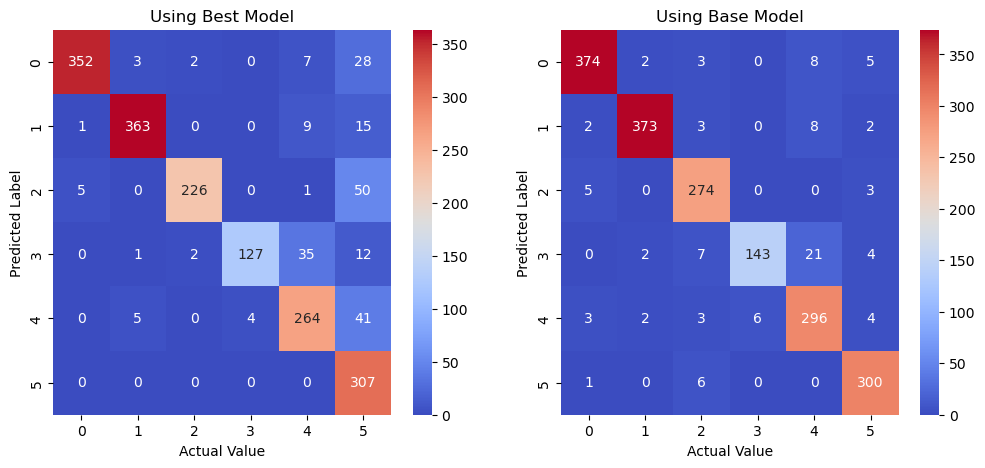

In [376]:
y_pred_best=rfcv_bestmodel.predict(x_test_finalcv)
cm_best = confusion_matrix(y_test, y_pred_best)
y_pred_original=rf.predict(x_test_finalcv)
cm_original = confusion_matrix(y_test, y_pred_original)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_best, annot=True, fmt='g', cmap='coolwarm', ax=axes[0])
axes[0].set_xlabel("Actual Value")
axes[0].set_ylabel("Predicted Label")
axes[0].set_title("Using Best Model")

sns.heatmap(cm_original, annot=True, fmt='g', cmap='coolwarm', ax=axes[1])
axes[1].set_xlabel("Actual Value")
axes[1].set_ylabel("Predicted Label")
axes[1].set_title("Using Base Model")

plt.show()

As we can observe from this confusion matrix alone, we can see that more values are predicted incorrectly for the best model. There might be some issues with the best model that could not be identified. As such, I will try out for the next few models.

##### **SMOTE**
We now continue our modelling by using SMOTE with Random Forest. SMOTE will ensure equal target variable distribution, as represented previously.

In [313]:
smote = SMOTE() 
x_train_cv_resampled, y_resampled = smote.fit_resample(x_train_finalcv, y_train)

In [314]:
rf_smoted = RandomForestClassifier(random_state=42)
rf_smoted.fit(x_train_cv_resampled,y_resampled)

RandomForestClassifier(random_state=42)

In [315]:
y_pred=rf_smoted.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.932258064516129
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       392
           1       0.99      0.93      0.96       388
           2       0.94      0.93      0.93       282
           3       0.85      0.86      0.85       177
           4       0.88      0.90      0.89       314
           5       0.92      0.98      0.95       307

    accuracy                           0.93      1860
   macro avg       0.92      0.93      0.92      1860
weighted avg       0.93      0.93      0.93      1860

weighted f1 score: 0.9324812885875715
macro f1 score: 0.9247381436071148
      


As we can see, the results are in fact poorer than that of the base mdodel. Thus, we will not be considering this model for final evaluation.

##### **Tomek Links**
We will now conduct modelling using TomekLinks. Tomek Links will undersample the dataset to ensure an equal balance.

In [341]:
l = TomekLinks()
x_train_cv_tomekked, y_resampled = tl.fit_resample(x_train_finalcv, y_train)


In [342]:
rf_tommeked = RandomForestClassifier(random_state=42)
rf_tommeked.fit(x_train_cv_tomekked,y_resampled)

RandomForestClassifier(random_state=42)

In [343]:
y_pred=rf_tommeked.predict(x_test_finalcv)

print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')


Accuracy: 0.9349462365591398
classification report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       392
           1       0.98      0.95      0.96       388
           2       0.91      0.96      0.94       282
           3       0.97      0.78      0.86       177
           4       0.88      0.92      0.90       314
           5       0.94      0.98      0.96       307

    accuracy                           0.93      1860
   macro avg       0.94      0.92      0.93      1860
weighted avg       0.94      0.93      0.93      1860

weighted f1 score: 0.9344191356521403
macro f1 score: 0.9276470248923591
      


We can observe that the TomekLinks model does relatively well, but some finetuning might be required.

In [377]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

param_dist = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
    'max_depth': [3, 5, 7, 10, None],  # Maximum depth of each tree (None means no limit)
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to bootstrap samples when building trees
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_tommeked,
    param_distributions=param_dist,
    n_iter=7,  # Number of random combinations to try
    scoring='accuracy',
    random_state=42,
)


# Fit RandomizedSearchCV
random_search.fit(x_train_finalcv, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=7,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [378]:
best_model = random_search.best_estimator_
# Print best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")
y_pred = best_model.predict(x_test_finalcv)

# Generate classification report
print(f'''
Accuracy: {accuracy_score(y_test,y_pred)}
classification report: 
{classification_report(y_test, y_pred)}
weighted f1 score: {f1_score(y_test, y_pred, average='weighted')}
macro f1 score: {f1_score(y_test, y_pred, average='macro')}
      ''')

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}

Accuracy: 0.9182795698924732
classification report: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       392
           1       0.94      0.95      0.95       388
           2       0.92      0.96      0.94       282
           3       0.99      0.62      0.76       177
           4       0.81      0.89      0.85       314
           5       0.94      0.98      0.96       307

    accuracy                           0.92      1860
   macro avg       0.93      0.89      0.90      1860
weighted avg       0.92      0.92      0.92      1860

weighted f1 score: 0.9157263387122757
macro f1 score: 0.9021925717947689
      


In [379]:
rf_tommeked_bestmodel=best_model
rf_tommeked

RandomForestClassifier(random_state=42)

After finetuning, the performance of the model is way lower than that of the base model, this means that the model here is relatively similar in condition to that of the Random Forest Base model where the finetuned model predicts much worse than that of the finetuned model. 

### <strong><ins> Model Comparison </strong></ins>

We now compare all the models that are available: 
| Model               | Base Model F1 Score (Base) | Base Model F1 Score (Finetuned) | Tomek Links F1 Score (Base) | Tomek Links F1 Score (Finetuned) |
|---------------------|----------------------------|---------------------------------|-----------------------------|----------------------------------|
| Logistic Regression | 0.93876   | 0.9376192   | 0.93387   | 0.93763  |
| Linear SVC    |  0.94352   | 0.94350  | 0.94139  | 0.941312 |
| Random Forest  | 0.9459  | 0.88425    | 0.934946 | 0.915726  |

From the above models, we can determine that the best models to be tested are: 
- Random Forest Base Model (Base)
- Linear SVC Tomek Links (Finetuned)
- Logistic Regression Base Model (Base)

### <strong><ins>Testing on Unseen Data </strong></ins>
We now import the necessary libraries and data

In [252]:
#test data
test = pd.read_csv('test_set.csv')

In [2]:
import dill
with open('text_preprocessing.pkl', 'rb') as f: 
    text_preprocessing = dill.load(f)
text_preprocessing

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.3.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Pipeline(steps=[('lowercase',
                 FunctionTransformer(func=<function <lambda> at 0x145b92660>)),
                ('filer_start',
                 FunctionTransformer(func=<function <lambda> at 0x145eda3e0>)),
                ('remove_stopwords',
                 FunctionTransformer(func=<function <lambda> at 0x145eda480>)),
                ('remove_punctuation',
                 FunctionTransformer(func=<function <lambda> at 0x145eda520>)),
                ('lemmatise',
                 FunctionTransformer(func=<function <lambda> at 0x145eda5c0>))])

In [3]:
with open('feature_engineering.pkl', 'rb') as f:
    feature_engineering_pipeline = dill.load(f)
feature_engineering_pipeline

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x145edb380>)),
                ('label_encoding_ratings',
                 FunctionTransformer(func=<function label_encoding at 0x145edb2e0>))])

In [4]:
import joblib
joblib.dump(feature_engineering_pipeline, 'feature_engineering.joblib')


PicklingError: Can't pickle <function feature_engineering at 0x145edb380>: it's not found as __main__.feature_engineering

Now we will activate our cleaning and preprocessing functions. 

In [255]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
#start off with converting to lowercase and remove any additional whitespaces
def lowercase(text): 
    text=text.lower()
    text=re.sub(r'\s\s+', ' ', text)
    return text

#remove starting words which are not relevant like trip verified/verified review 
def filter_startwords(text):
    text=re.sub(r'([^a-zA-Z]+trip verified[^a-zA-Z]+)', '', text)
    text=re.sub(r'([^a-zA-Z]+verified review[^a-zA-Z]+)', '', text)
    return text

def remove_stopwords(x): 
    stopwordss=stopwords.words('english')
    stopwordss.extend(['would','u', 'not'])
    words=word_tokenize(x)
    text=[]
    for word in words: 
        if word not in stopwordss: 
            text.append(word)
    return ' '.join(text)

import string
def remove_punctuation(x):
    punct=list(string.punctuation)
    text=[]
    words=word_tokenize(x)
    for word in words: 
        if word not in punct: 
            text.append(word)
    return ' '.join(text)

def remove_others_lemmatise(x): 
    lemma=WordNetLemmatizer() #lemmatization
    wordslist=['``', '`']
    words=word_tokenize(x)
    txt=[]
    for word in words: 
        if word not in wordslist: 
            if word == "n't": 
                word='not'
                txt.append(word)
            else:
                word=lemma.lemmatize(word)
                txt.append(word)
    return ' '.join(txt)



In [256]:
from tqdm import tqdm
tqdm.pandas()
test['cleaned_text']=text_preprocessing.transform(test['content'])

100%|██████████| 643/643 [00:00<00:00, 2188.12it/s]


In [257]:
from textblob import TextBlob
def categorize_rating(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

def feature_engineering(df): 
    df['word_count']=df['cleaned_text'].apply(lambda x:len(str(x).split()))
    df['char_count']=df['cleaned_text'].apply(lambda x:len(x))
    df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)  # Avoid division by zero
    df['sentiment_score'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity_score'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['rating_category'] = df['rating'].apply(categorize_rating)
    df['sentiment_agreement'] = df.apply(lambda row: 1 if (row['sentiment_score'] > 0 and row['rating'] > 3) or
                                                       (row['sentiment_score'] < 0 and row['rating'] <= 2) 
                                          else 0, axis=1)
    return df

def label_encoding(df): 
    label_encoding=LabelEncoder()
    df['rating_encoded']=label_encoding.fit_transform(df['rating_category'])
    return df
    

In [258]:
test=feature_engineering_pipeline.transform(test)

In [259]:
test['airlines']=test['airline']
test['cleaned_text'] = test['cleaned_text'].where(test['word_count'] >= 50, np.NaN)
test.dropna(inplace=True)

In [260]:
testset = test.drop(['airline', 'Unnamed: 0','content', 'rating','rating_category'],axis=1)
testset.head()

,cleaned_text,word_count,char_count,avg_word_length,sentiment_score,subjectivity_score,sentiment_agreement,rating_encoded,airlines
0,verified travelled singapore airline many year...,113,813,7.131579,-0.027632,0.527632,0,1,Singapore Airlines
3,ek 772 cpt dxb flight boeing 777-300. boarding...,60,346,5.672131,0.288889,0.605556,1,2,Emirates
4,booked fairly priced return ticket dublin edin...,79,500,6.250000,-0.036905,0.522619,1,0,Ryanair
5,thought possible worse call centre experience ...,70,471,6.633803,-0.035897,0.530769,1,0,Singapore Airlines
6,chicago midway newark irritating travel airlin...,93,683,7.265957,-0.050818,0.410789,1,0,Southwest Airlines


In [261]:
from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
testset['airlines_encoded']=le.transform(testset['airlines'])

In [262]:
test_x=  testset[['cleaned_text','sentiment_score', 'subjectivity_score']]
test_y = testset['airlines_encoded']

In [263]:
testx_text = test_x['cleaned_text']
testx_numeric = test_x.drop('cleaned_text',axis=1)

In [264]:
testx_numeric_scaled=scaler.transform(testx_numeric)
testx_numeric_scaled = pd.DataFrame(testx_numeric_scaled, columns=testx_numeric.columns, index=testx_numeric.index)
testx_numeric = testx_numeric_scaled.reset_index()
testx_cv = cv.transform(testx_text)
testx_vectorised = pd.DataFrame(testx_cv.toarray(), columns=cv.get_feature_names_out())
testx_vectorised.reset_index(drop=True,inplace=True)
testing_set_x  = pd.concat([testx_vectorised,testx_numeric],axis=1)
testing_set_x

In [271]:
testing_set_x.drop('index',axis=1, inplace=True)

#### Model Implementation
We now implement the models

We first start off with the logistic regression base model (base) without finetuning. 

In [347]:
y_pred=lr_cv.predict(testing_set_x)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print(f'''
Accuracy: {accuracy_score(test_y,y_pred)}
classification report: 
{classification_report(test_y, y_pred)}
weighted f1 score: {f1_score(test_y, y_pred, average='weighted')}
macro f1 score: {f1_score(test_y, y_pred, average='macro')}
      ''')


Accuracy: 0.9434447300771208
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        86
           1       0.96      0.97      0.96        70
           2       0.90      0.98      0.94        63
           3       0.92      0.87      0.89        39
           4       0.92      0.92      0.92        64
           5       0.97      0.97      0.97        67

    accuracy                           0.94       389
   macro avg       0.94      0.94      0.94       389
weighted avg       0.94      0.94      0.94       389

weighted f1 score: 0.9433407583070827
macro f1 score: 0.939466971125647
      


We noow do the Random Forest base Model

In [348]:
y_pred=rf.predict(testing_set_x)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print(f'''
Accuracy: {accuracy_score(test_y,y_pred)}
classification report: 
{classification_report(test_y, y_pred)}
weighted f1 score: {f1_score(test_y, y_pred, average='weighted')}
macro f1 score: {f1_score(test_y, y_pred, average='macro')}
      ''')


Accuracy: 0.922879177377892
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        86
           1       0.96      0.97      0.96        70
           2       0.86      0.94      0.89        63
           3       0.97      0.82      0.89        39
           4       0.87      0.92      0.89        64
           5       0.94      0.97      0.96        67

    accuracy                           0.92       389
   macro avg       0.93      0.92      0.92       389
weighted avg       0.93      0.92      0.92       389

weighted f1 score: 0.9228356305005779
macro f1 score: 0.9197335263355289
      


Lastly we will do the Linear SVC Tomek Links (Finetuned)

In [349]:
y_pred=linearsvm_tomek.predict(testing_set_x)

from sklearn.metrics import accuracy_score, f1_score, classification_report
print(f'''
Accuracy: {accuracy_score(test_y,y_pred)}
classification report: 
{classification_report(test_y, y_pred)}
weighted f1 score: {f1_score(test_y, y_pred, average='weighted')}
macro f1 score: {f1_score(test_y, y_pred, average='macro')}
      ''')


Accuracy: 0.9383033419023136
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        86
           1       0.94      0.97      0.96        70
           2       0.93      0.98      0.95        63
           3       0.88      0.90      0.89        39
           4       0.92      0.91      0.91        64
           5       0.97      0.96      0.96        67

    accuracy                           0.94       389
   macro avg       0.93      0.94      0.93       389
weighted avg       0.94      0.94      0.94       389

weighted f1 score: 0.9382127210821926
macro f1 score: 0.9345986934037792
      


#### <strong><ins> Evaluation and Conclusion </ins></strong>
| Model | Accuracy | Weighted F1 Score | Macro F1 Score | 
|---------------------|----------------------------|---------------------------------|-----------------------------|
| Logistic Regression base Model (Base) | 0.94344 |0.943334 |0.939466| 
| Linear SVC  Tomek Links (Finetuned)  |0.938303 |0.938212 |0.934598 |
| Random Forest Base Model (Base) |0.922879|0.922835 |0.919733 |

With this, we can now determine that the best model here is Logistic Regression Base Model using Count Vectorizer.